# Combine workgraphs

## Introduction

In designing a complex workflow, it is often desired to reuse smaller, reusable components. In the following sections, we'll create a simple workgraph and integrate it into another.

## Define a workgraph

To start, let's define a workgraph to add two numbers and multiply the sum by a third.

In [1]:
from aiida_workgraph import WorkGraph, task


with WorkGraph("AddMultiply") as wg1:
    wg1.inputs = dict.fromkeys(["x", "y", "z"])
    wg1.outputs.result = (wg1.inputs.x + wg1.inputs.y) * wg1.inputs.z

wg1.to_html()

We can see our two tasks, the linking of the sum to the first multiplication factor, and the assignment of the product as the final workgraph result.

We're now ready to integrate our new **AddMultiply** workgraph into other workgraphs.

## Add a workgraph as a task

Adding a workgraph as a task of another is straightforward. We define a new workgraph, **AddMultiplyWorkGraph**, with a new task to generate a random number. We then call the **AddMultiply** workgraph as a task within this new workgraph, assigning the random number to the `z` input (the multiplication factor). Finally, we set the output of the **AddMultiply** workgraph as the output of the **AddMultiplyWorkGraph**.

In [2]:
@task
def generate_random_number(minimum, maximum):
    import random

    return random.randint(minimum, maximum)


with WorkGraph("AddMultiplyComposed") as wg2:
    wg2.inputs = dict.fromkeys(["min", "max", "x", "y"])

    outputs1 = generate_random_number(
        minimum=wg2.inputs.min,
        maximum=wg2.inputs.max,
    )

    outputs2 = wg1(
        inputs={
            "x": wg2.inputs.x,
            "y": wg2.inputs.y,
            "z": outputs1.result,
        }
    )

    wg2.outputs.result = outputs2.result

wg2.to_html()

See how we're using **AddMultiply** as a regular task? It's as simple as that!

Let's run our new workgraph and have a look at its result.

In [3]:
from aiida import load_profile

_ = load_profile()

wg2.run(
    inputs={
        "graph_inputs": {
            "min": 1,
            "max": 10,
            "x": 1,
            "y": 2,
        }
    }
)

07/12/2025 03:25:58 PM <1139792> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [10360|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_random_number
07/12/2025 03:25:58 PM <1139792> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [10360|WorkGraphEngine|update_task_state]: Task: generate_random_number, type: PyFunction, finished.
07/12/2025 03:25:58 PM <1139792> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [10360|WorkGraphEngine|continue_workgraph]: tasks ready to run: workgraph_task
07/12/2025 03:25:59 PM <1139792> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [10360|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 10365
[REPORT] [10360|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 10365
07/12/2025 03:25:59 PM <1139792> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [10365|WorkGraphEngine|continue_workgraph]: tasks ready 

Let's have a look at the provenance graph.

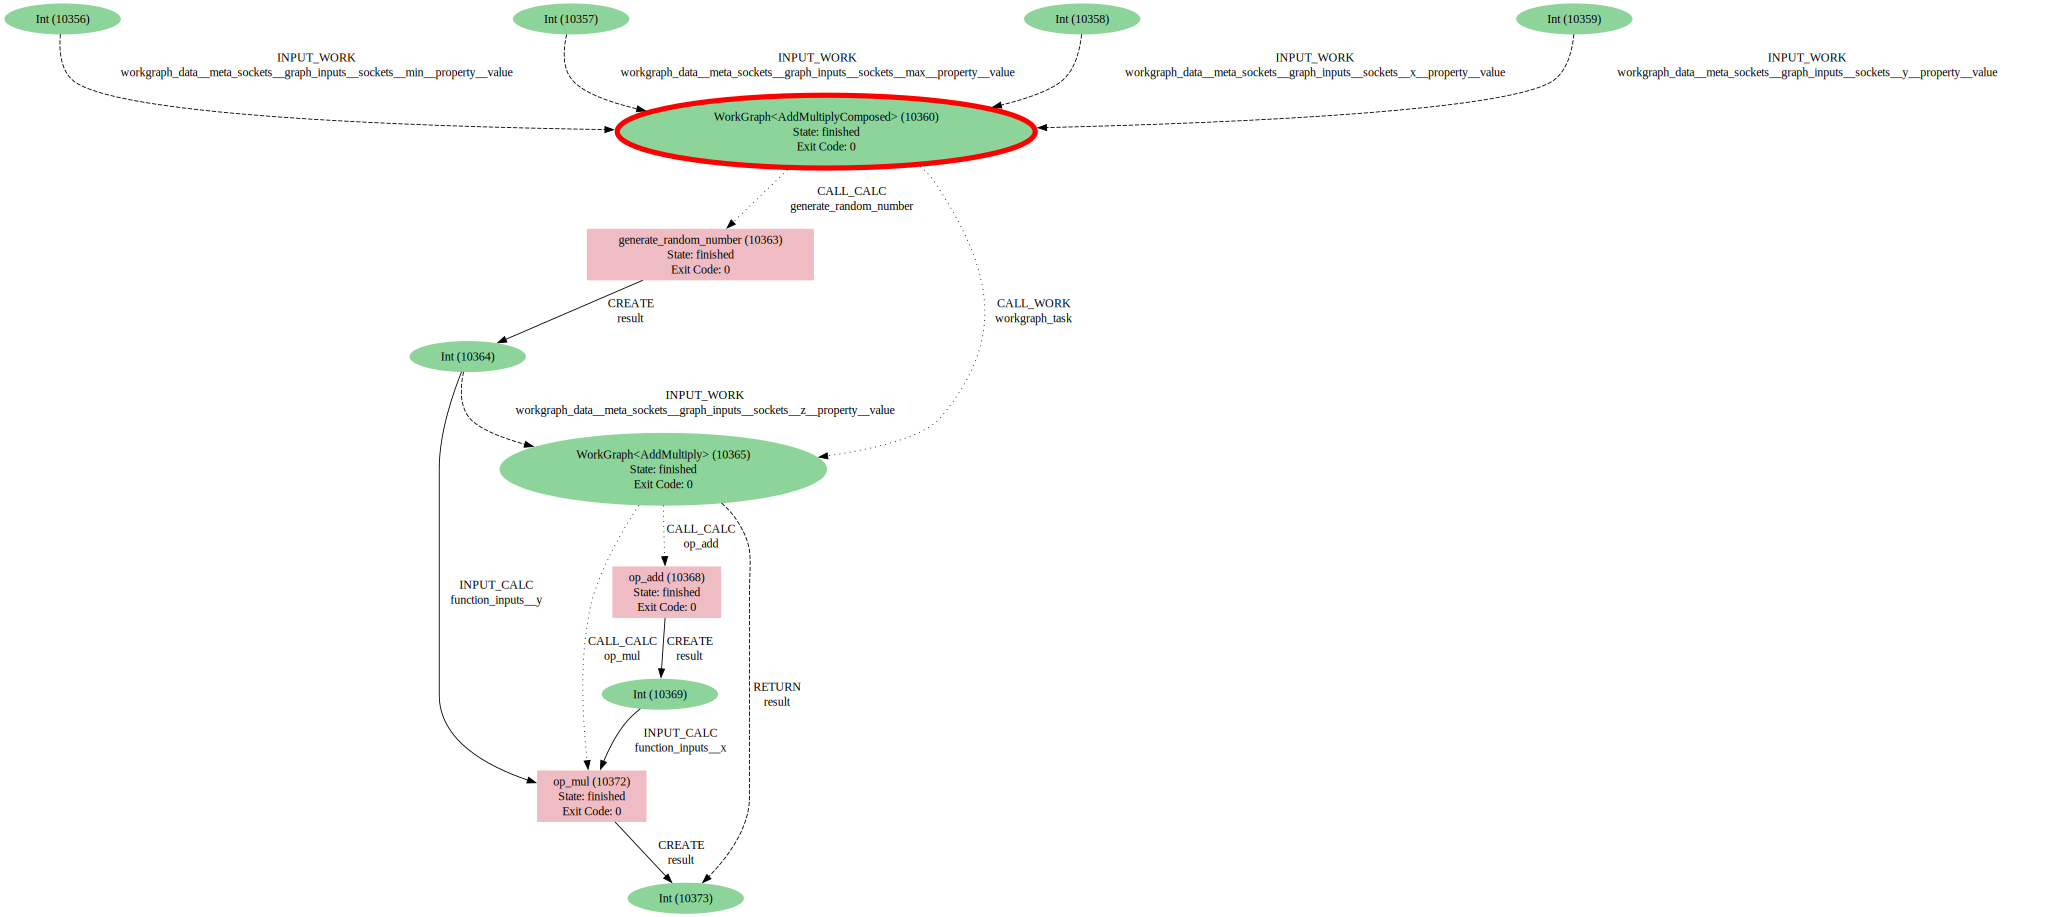

In [5]:
from aiida_workgraph.utils import generate_node_graph

generate_node_graph(wg2.pk)

## Making it reusable

Now, how do we make this reusable? Simple! We just wrap **AddMultiply** in a generating function.

In [6]:
def generate_add_multiply_workgraph():
    with WorkGraph("AddMultiply") as wg:
        wg.inputs = dict.fromkeys(["x", "y", "z"])
        wg.outputs.result = (wg.inputs.x + wg.inputs.y) * wg.inputs.z
    return wg

Now we can generate one anytime we need an **AddMultiply** workgraph in our workflows.

## Summary

Combining workgraphs is a straightforward process that allows for a modular approach to workflow design. By defining reusable components, we can easily integrate them into larger workflows, enhancing maintainability and readability. The example provided demonstrates how to create a simple workgraph and incorporate it into another, showcasing the flexibility of the AiiDA WorkGraph framework.